<a href="https://colab.research.google.com/github/edmrch/TimeSeries/blob/main/Air_Passagers_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This case is the first test using 3 types of forecasting methods: Moving Average, AutoRegression and Holts-Winter. The dataset I took from kaggle and is about quantity of passagers:
https://www.kaggle.com/datasets/ashfakyeafi/air-passenger-data-for-time-series-analysis

This analasis was made in Google Collab!

In [3]:
##Libreries
from google.colab import files
files.upload("C:/Users/Emman/OneDrive/Área de Trabalho/Data/AirpassagersComplete.xlsx")
#PlOTS
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

#Data Manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import scipy.stats as stats
# Time Series
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error

Saving AirpassagersComplete.xlsx to C:/Users/Emman/OneDrive/Área de Trabalho/Data/AirpassagersComplete.xlsx/AirpassagersComplete.xlsx


In [4]:
#Import Data
data = pd.read_excel("C:/Users/Emman/OneDrive/Área de Trabalho/Data/AirpassagersComplete.xlsx/AirpassagersComplete.xlsx")
display(data)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [5]:
#Plot original Series
figure = px.line(data,data['Month'],data['#Passengers'],labels={'Month','Passangers'})
figure.update_layout(template="simple_white")
figure.show()

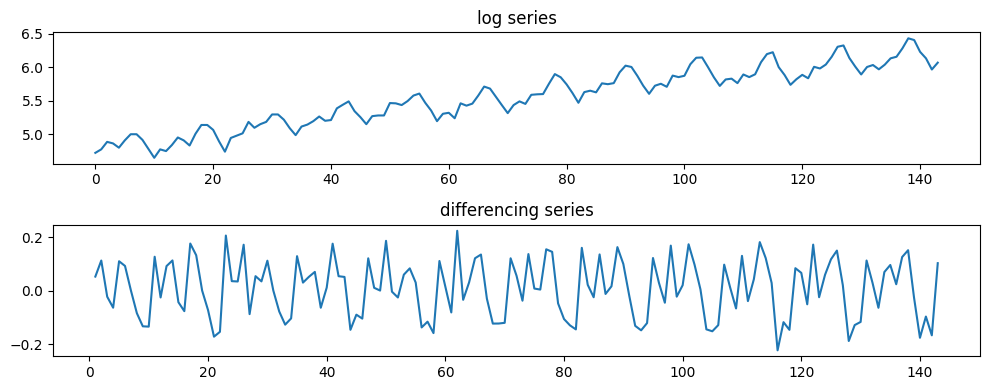

In [6]:
#Using log and differencing
data['Passengers_log'] = np.log(data['#Passengers'])
data['Passengers_log_dif'] = data['Passengers_log'].diff().dropna()

plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.title('log series')
plt.plot(data['Passengers_log']) # smoothing standard deviation
plt.subplot(2,1,2)
plt.title('differencing series')
plt.plot(data['Passengers_log_dif']) # smoothing mean
plt.tight_layout()

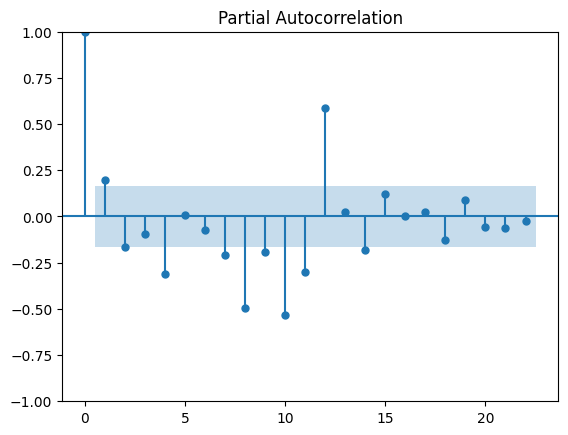

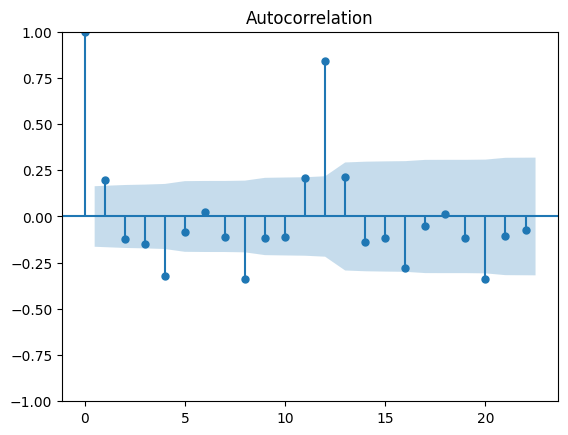

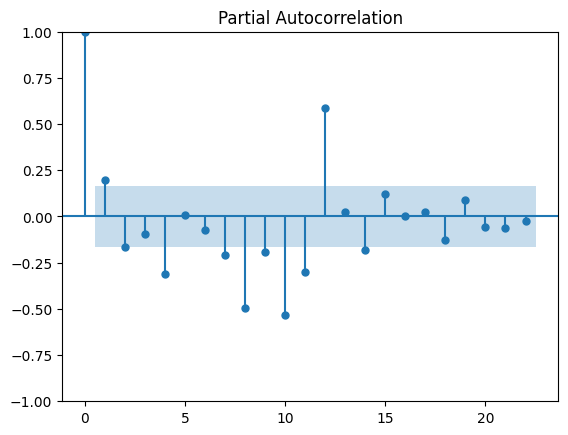

In [7]:
# Check the ACF and the PACF
plot_acf(data['Passengers_log_dif'].dropna())
plot_pacf(data['Passengers_log_dif'].dropna(), method='ywm')

In [8]:
# Split Train and Test ( 80% of the series is for training and 20% for testing)
train_df = data.iloc[:-int(144 * 0.2)]
test_df = data.iloc[-int(144 * 0.2):]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

<ipython-input-9-84501905ec1b>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-84501905ec1b>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-

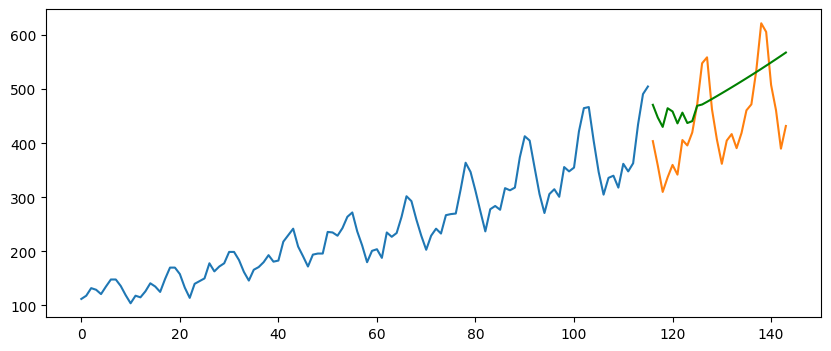

In [9]:
#MOVING AVERAGE MODEL
# training and fitting the series
ma_model = ARIMA(train_df['Passengers_log_dif'],order=(0,0,12))
fit_ma = ma_model.fit()
#fit_ma.summary()
# Forecast future values. Lenght equal to test set
test_df['transformed_forecasts'] = list(fit_ma.forecast(steps=len(test_df)))
#Reverse the differencing
last_train_data = train_df['Passengers_log'].iloc[-1]
test_df['Passengers_cumsum'] = test_df['transformed_forecasts'].cumsum() + last_train_data #don´t allow cumsum in a list
test_df['passagers_MA_model'] = np.exp(test_df['Passengers_cumsum'])

plt.figure(figsize=(10,4))
plt.plot(train_df['#Passengers'],label='series')
plt.plot(test_df['#Passengers'],label='Original')
plt.plot(test_df['passagers_MA_model'],label='Model', color='green')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/st

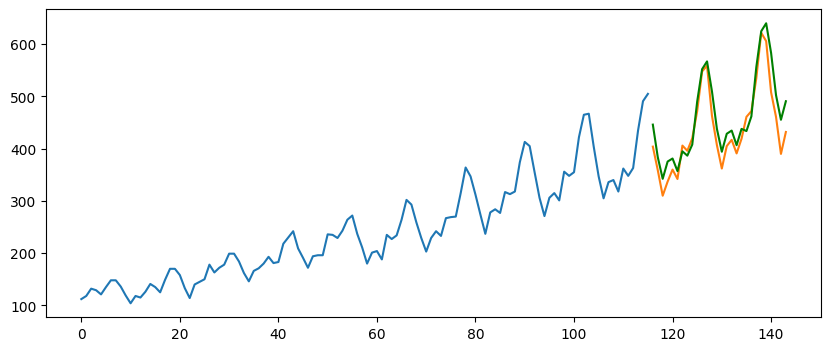

In [17]:
#AUTO REGRESSION MODEL
selector = ar_select_order(train_df['Passengers_log_dif'].dropna(), 15)
model_ar = AutoReg(train_df['Passengers_log_dif'].dropna(), lags=selector.ar_lags).fit()
test_df['transformed_ar_forecast'] = list(model_ar.forecast(steps=len(test_df)))

last_train_data = train_df['Passengers_log'].iloc[-1]
test_df['Passengers_cumsum_ar'] = test_df['transformed_ar_forecast'].cumsum() + last_train_data #don´t allow cumsum in a list
test_df['passagers_AR_model'] = np.exp(test_df['Passengers_cumsum_ar'])

plt.figure(figsize=(10,4))
plt.plot(train_df['#Passengers'],label='series')
plt.plot(test_df['#Passengers'],label='Original')
plt.plot(test_df['passagers_AR_model'],label='Model', color='green')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning:

overflow encountered in matmul



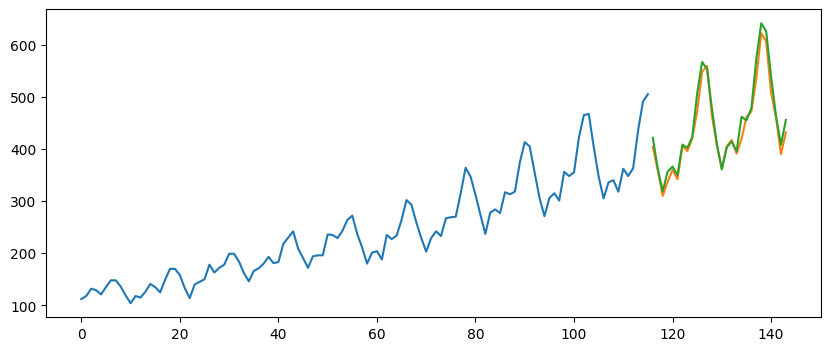

In [11]:
# HOLTS WINTER MODEL
model_holt_winters = ExponentialSmoothing(train_df['#Passengers'], trend='mul',
                                          seasonal='mul', seasonal_periods=12)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(test_df))
plt.figure(figsize=(10,4))
plt.plot(train_df['#Passengers'],label='series')
plt.plot(test_df['#Passengers'],label='Original')
plt.plot(forecasts_holt_winters,label='Model')

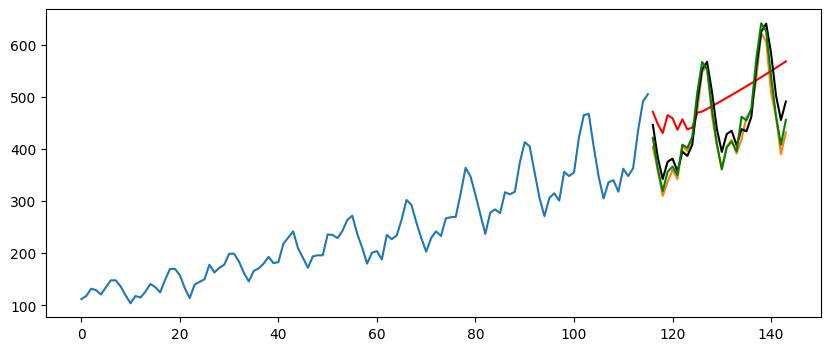

In [12]:
# Comparing to check what model is better
plt.figure(figsize=(10,4))
plt.plot(train_df['#Passengers'],label='series')
plt.plot(test_df['#Passengers'],label='Original')
plt.plot(test_df['passagers_MA_model'],label='Model', color='red')
plt.plot(test_df['passagers_AR_model'],label='Model', color='black')
plt.plot(forecasts_holt_winters,label='Model', color='green')

In [13]:
# Mean Absolute Error (MAE)
MAE_MA = ((test_df['passagers_MA_model'] - test_df['#Passengers']).sum()/test_df['#Passengers'].count())
MAE_AR = ((test_df['passagers_AR_model'] - test_df['#Passengers']).sum()/test_df['#Passengers'].count())
MAE_HW = ((forecasts_holt_winters - test_df['#Passengers']).sum()/test_df['#Passengers'].count())
display(MAE_MA, MAE_AR, MAE_HW)
# Mean Squared Error (MSE)
MSE_MA = ((test_df['passagers_MA_model'] - test_df['#Passengers']).sum()**2)
MSE_AR = ((test_df['passagers_AR_model'] - test_df['#Passengers']).sum()**2)
MSE_HW = ((forecasts_holt_winters - test_df['#Passengers']).sum()**2)
display(MSE_MA,MSE_AR,MSE_HW)

56.42058727385944

22.190226261710023

11.770088051480146

2495693.611968517

386046.414971974

108611.41862784303

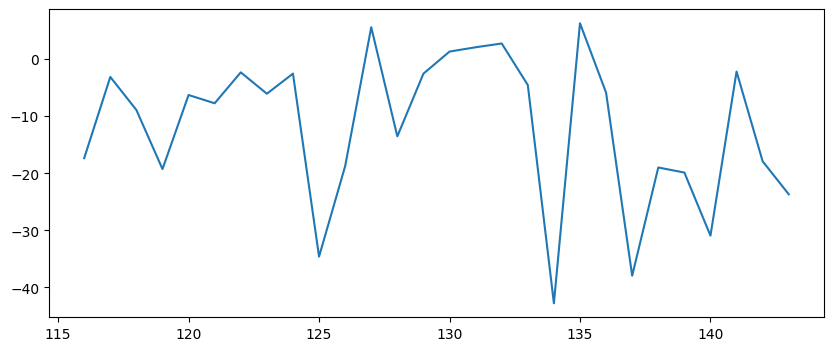

In [16]:
residuals_HW = test_df['#Passengers'] - forecasts_holt_winters
plt.figure(figsize=(10,4))
plt.plot(residuals_HW)

using the time series libreries available in Python, was compared 3 methods and at the end the Holt Winters show better results, comparing to the test set. After the comparing of the methods was create a simple analisis to check if residuals have any pattern. check the graph it show that don´t have any pattern, so the distribuiton are random (white noise).
